# Learning To Rank(ランキング学習)のトレーニングとデプロイ方法

このノートブックでは、以下のことを行います。

- 公式の Python クライアントを使用して、Elasticsearch デプロイメントに接続します。
- 映画のデータセットをインポートして、Elasticsearch にインデックスします。
- カスタム script_score クエリを含む Elasticsearch のクエリ DSL を使用して、データセットから特徴量を抽出します。
- 抽出された特徴量と人間がキュレーションした評価リストを組み合わせて、トレーニングデータセットを構築します。
- [XGBoost](https://xgboost.ai/) を使用して、Learning To Rank モデルをトレーニングします。
- トレーニング済みモデルを、o19sのエンドポイントを使用して Elasticsearch にデプロイします。
- モデルを 2 段階目の再ランキングのためのリスコアラーとして使用します。
- モデルを適用する前と後の検索結果を比較して、LTR モデルが検索関連性に与える影響を評価します。

> **注意:**
> o19sのLtRプラグインはEsの8.14.3までしか対応していません（2024/10/24現在）。



## 必要なパッケージのインストール

（Dockerfile内でpoetryを利用して必要なものはインストールされる仕組みに変更したのでちょっとした確認だけ）
[pyproject.toml](../pyproject.tomlpy)を参照のこと

In [32]:
from tqdm import tqdm

# Setup the progress bar so we can use progress_apply in the notebook.
tqdm.pandas()

## Elasticsearchへの接続

ローカル（今回はDockerのネットワーク）にあるEsに接続します。

In [33]:
from elasticsearch import Elasticsearch

ES_URL = "http://es-o19s:9200"

# Create the client instance
es_client = Elasticsearch(
    # For local development
    hosts=[ES_URL]
)

### クライアントの接続確認
いろいろやる前に接続確認します。


In [34]:
client_info = es_client.info()

f"Successfully connected to cluster {client_info['cluster_name']} (version {client_info['version']['number']})"

'Successfully connected to cluster o19s-es-cluster (version 8.14.3)'

## データセットの設定

[MSRD (Movie Search Ranking Dataset)](https://github.com/metarank/msrd/tree/master)のデータセットを利用します。

データセットは[こちら](](https://github.com/elastic/elasticsearch-labs/tree/main/notebooks/search/sample_data/learning-to-rank/))からダウンロードします。次のファイルが含まれています。

- `movies_corpus.jsonl.gz`: インデックスする映画のデータセット
- `movies_judgements.tsv.gz`: クエリとそれに関連するジャッジメントリスト
- `movies_index_settings.json`: ドキュメントとインデックスの設定

In [35]:
from urllib.parse import urljoin

DATASET_BASE_URL = "https://raw.githubusercontent.com/elastic/elasticsearch-labs/main/notebooks/search/sample_data/learning-to-rank/"

CORPUS_URL = urljoin(DATASET_BASE_URL, "movies-corpus.jsonl.gz")
JUDGEMENTS_FILE_URL = urljoin(DATASET_BASE_URL, "movies-judgments.tsv.gz")
INDEX_SETTINGS_URL = urljoin(DATASET_BASE_URL, "movies-index-settings.json")

 ## ドキュメントコーパスのインポートImport the document corpus

このステップでは、コーパスの文書を `movies` インデックスにインポートする。 

Documentsには以下のフィールドが含まれる：

| Field name   | Description                                 |
|--------------|---------------------------------------------|
| `id`         | ドキュメントのID                              |
| `title`      | 映画のタイトル                                |
| `overview`   | 映画の短い概要                                |
| `actors`     | 映画の出演俳優のリスト                         |
| `director`   | 映画の監督                                   |
| `characters` | List of characters that appear in the movie |
| `genres`     | 映画のジャンル                                |
| `year`       | 公開年                                       |
| `budget`     | 映画の予算（USD）                             |
| `votes`      | 映画の得票数                                  |
| `rating`     | 映画の平均レーティング                          |
| `popularity` | 映画の人気度                                  |
| `tags`       | タグのリスト                                  |



In [36]:
import json
import elasticsearch.helpers as es_helpers
import pandas as pd
from urllib.request import urlopen

MOVIE_INDEX = "movies"

# Delete index
print("Deleting index if it already exists:", MOVIE_INDEX)
es_client.options(ignore_status=[400, 404]).indices.delete(index=MOVIE_INDEX)

print("Creating index:", MOVIE_INDEX)
index_settings = json.load(urlopen(INDEX_SETTINGS_URL))
es_client.indices.create(index=MOVIE_INDEX, **index_settings)

print(f"Loading the corpus from {CORPUS_URL}")
corpus_df = pd.read_json(CORPUS_URL, lines=True)

print(f"Indexing the corpus into {MOVIE_INDEX} ...")
bulk_result = es_helpers.bulk(
    es_client,
    actions=[
        {"_id": movie["id"], "_index": MOVIE_INDEX, **movie}
        for movie in corpus_df.to_dict("records")
    ],
)
print(f"Indexed {bulk_result[0]} documents into {MOVIE_INDEX}")

Deleting index if it already exists: movies
Creating index: movies
Loading the corpus from https://raw.githubusercontent.com/elastic/elasticsearch-labs/main/notebooks/search/sample_data/learning-to-rank/movies-corpus.jsonl.gz
Indexing the corpus into movies ...
Indexed 9750 documents into movies


登録されているドキュメントのサンプル

In [37]:
sample_response = es_client.search(index=MOVIE_INDEX)

pd.DataFrame(
    columns=["_id", "title", "actors", "genres", "popularity", "year"],
    data=[
        (movie["_id"], movie["_source"]["title"], movie["_source"]["actors"], movie["_source"]["genres"], movie["_source"]["popularity"], movie["_source"]["year"])
    for movie in sample_response["hits"]["hits"]
    ]
)

,_id,title,actors,genres,popularity,year
0,436270,Black Adam,"[Sarah Shahi, Dwayne Johnson, Henry Cavill, Pi...","[Action, Fantasy, Science Fiction]",6202.882,2022
1,882598,Smile,"[Kyle Gallner, Sosie Bacon, Caitlin Stasey, Ka...","[Horror, Mystery, Thriller]",3910.444,2022
2,505642,Black Panther: Wakanda Forever,"[Letitia Wright, Angela Bassett, Tenoch Huerta...","[Action, Adventure, Science Fiction]",3492.065,2022
3,966220,Sniper: The White Raven,"[Maryna Koshkina, Roman Semysal, Andrei Mostre...","[Drama, Action, War]",2403.163,2022
4,663712,Terrifier 2,"[Lauren LaVera, David Howard Thornton, Katie M...","[Horror, Thriller]",2015.172,2022
5,829280,Enola Holmes 2,"[Millie Bobby Brown, Louis Partridge, Henry Ca...","[Mystery, Adventure, Crime]",1787.272,2022
6,676701,Tad the Lost Explorer and the Emerald Tablet,"[Michelle Jenner, Cecilia Suárez, Alexandra Ji...","[Adventure, Animation, Comedy]",1833.372,2022
7,675054,MexZombies,"[Bárbara de Regil, Sara Maldonado, Alejandro P...","[Horror, Action, Comedy]",1454.895,2022
8,979924,On the Line,"[Mel Gibson, Kevin Dillon, Enrique Arce, Willi...",[Thriller],1471.212,2022
9,948276,Lost Bullet 2,"[Alban Lenoir, Stéfi Celma, Pascale Arbillot, ...","[Action, Drama, Thriller]",1380.782,2022


## ジャッジメントリストのロード

ジャッジメントリストには、ランキング学習モデルの学習に使用する人による評価が含まれています。

各行は関連するクエリとドキュメントのペアを表し、関連性グレードをもっています。
以下のカラムを含みます：


| Column    | Description                                                            |
|-----------|------------------------------------------------------------------------|
| `query_id`| 同じクエリに対するペアはグループ化され、一意のIDが与えられる。                   |
| `query`   | クエリの実際のテキスト                                                    |
| `doc_id`  | ドキュメントのID                                                         |
| `grade`   | クエリに対するドキュメントの関連性のグレード                                  |


**注意書き:**

今回の例では関連性のグレードは2値である（関連するかしないか）
関連性の度合いを表す数字を使うこともできる。(例 `0` から `4`)

In [38]:
judgments_df = pd.read_csv(JUDGEMENTS_FILE_URL, delimiter="\t")
judgments_df

,query_id,query,doc_id,grade
0,qid:5141,insidious 2 netflix,846433,0
1,qid:5141,insidious 2 netflix,49018,1
2,qid:5141,insidious 2 netflix,38234,0
3,qid:5141,insidious 2 netflix,567604,0
4,qid:5141,insidious 2 netflix,269795,0
...,...,...,...,...
384750,qid:3383,2013 the wolverine,263115,0
384751,qid:3383,2013 the wolverine,25913,0
384752,qid:3383,2013 the wolverine,567604,0
384753,qid:3383,2013 the wolverine,533535,0


## 特徴量の抽出に関する設定

特徴量（Features）はモデルのインプットです。 BM25スコアのように、クエリのみ、結果の文書のみ、またはクエリのコンテキストにおける結果の文書に関する情報を表します。

特徴量は、標準的なテンプレート化されたクエリとクエリDSLを使って定義されます。


In [39]:
# A feature set as a tuple, which looks a lot like JSON
feature_set = {
    "featureset": {
        "name": "movies_fieatures",
        "features": [
            {
                "name": "title_bm25",
                "params": ["query"],
                "template": {
                    "match": {"title": "{{query}}"}
                }
            },
            {
                "name": "actors_bm25",
                "params": ["query"],
                "template": {
                    "match": {"actors": "{{query}}"}
                }
            },
            {
                "name": "title_all_terms_bm25",
                "params": ["query"],
                "template": {
                    "match": {
                        "title": {"query": "{{query}}", "minimum_should_match": "100%"}
                    }
                }
            },
            {
                "name": "actors_all_terms_bm25",
                "params": ["query"],
                "template": {
                    "match": {
                        "actors": {"query": "{{query}}", "minimum_should_match": "100%"}
                    }
                }
            },
            {
                "name": "popularity",
                "params": [],
                "template": {
                    "script_score": {
                        "query": {"exists": {"field": "popularity"}},
                        "script": {"source": "return doc['popularity'].value;"},
                    }
                }
            }
        ]
    }
}
feature_set


{'featureset': {'name': 'movies_fieatures',
  'features': [{'name': 'title_bm25',
    'params': ['query'],
    'template': {'match': {'title': '{{query}}'}}},
   {'name': 'actors_bm25',
    'params': ['query'],
    'template': {'match': {'actors': '{{query}}'}}},
   {'name': 'title_all_terms_bm25',
    'params': ['query'],
    'template': {'match': {'title': {'query': '{{query}}',
       'minimum_should_match': '100%'}}}},
   {'name': 'actors_all_terms_bm25',
    'params': ['query'],
    'template': {'match': {'actors': {'query': '{{query}}',
       'minimum_should_match': '100%'}}}},
   {'name': 'popularity',
    'params': [],
    'template': {'script_score': {'query': {'exists': {'field': 'popularity'}},
      'script': {'source': "return doc['popularity'].value;"}}}}]}}

### Feature Setの登録

o19sのプラグインでは、Feature Setを登録するためのエンドポイントが用意されています。
こちらにFeature Setを登録します。

In [40]:
import requests

LTR_ENDPOINT = ES_URL + "/" + "_ltr"

def resp_msg(msg, resp, throw=True, ignore=[]):
    rsc = resp.status_code
    print('{} [Status: {}]'.format(msg, rsc))
    if rsc >= 400 and rsc not in ignore:
        if throw:
            raise RuntimeError(resp.text)

def reset_ltr():
    resp = requests.delete(LTR_ENDPOINT)
    resp_msg(msg="Removed Default LTR feature store".format(), resp=resp, throw=False)
    resp = requests.put(LTR_ENDPOINT)
    resp_msg(msg="Initialize Default LTR feature store".format(), resp=resp)

def create_featureset(name, ftr_config):
    resp = requests.post('{}/_featureset/{}'.format(LTR_ENDPOINT, name), json=ftr_config)
    resp_msg(msg="Create {} feature set".format(name), resp=resp)


In [41]:
reset_ltr()
create_featureset(name=feature_set["featureset"]["name"], ftr_config=feature_set)

Removed Default LTR feature store [Status: 200]
Initialize Default LTR feature store [Status: 200]
Create movies_fieatures feature set [Status: 201]


## トレーニングデータセットの構築

基本的なデータセットがロードされ、特徴量の抽出が設定されたので、ジャッジメントリストを使ってトレーニング用の最終的なデータセットを作成します。 データセットは `<query, document>` のペアを含む行と、モデルの学習に必要なすべての特徴量から構成されます。 このデータセットを生成するために、ジャッジメントリストから各クエリを実行し、抽出された特徴量をラベル付けされた各結果ドキュメントの列として追加します。

例えば、2つのラベル付き文書 `d3` と `d9` を持つクエリ `q1` があった場合、トレーニングデータセットは2行（`<q1, d3>` と `<q1, d9>`）になります。

これは Elasticsearch クラスタ上でクエリを実行するため、この操作の実行時間はクラスタがホストされている場所とこのノートブックが実行される場所によって異なることに注意してください。 例えば、Elasticsearch クラスタと同じサーバやホストでノートブックを実行した場合、サンプルデータセットではこの操作は非常に高速に実行される傾向があります（2分未満）。

> o19sのLtRプラグインでは学習関連のスクリプトなどは用意されていないので、次のようなFeatuerLoggerを独自で実装しています。

In [42]:
import re

class FeatureLogger:
    """ Logs LTR Features, one query at a time

        ...Building up a training set...
    """

    def __init__(self, client, index, feature_set, drop_missing=True):
        self.client=client
        self.index=index
        self.feature_set=feature_set
        self.drop_missing=drop_missing
        self.logged=[]

    def clear(self):
        self.logged=[]
    
    def extract_features(self, query_params, doc_ids):
        featuresPerDoc = {
            doc_id: [float("nan")] * len(self.feature_set["featureset"]["features"])
            for doc_id in doc_ids
        }
        
        res = self.log_query(doc_ids, query_params)
        for doc in res:
            docid = str(doc["id"])
            if docid in featuresPerDoc:
                featuresPerDoc[docid] = doc['ltr_features']
        
        return featuresPerDoc
    
    def log_query(self, ids, params={}):
        params = {
            "query": {
                "bool": {
                    "filter": [
                        {
                            "sltr": {
                                "_name": "logged_features",
                                "featureset": self.feature_set["featureset"]["name"],
                                "params": params
                            }
                        }
                    ]
                }
            },
            "ext": {
                "ltr_log": {
                    "log_specs": {
                        "name": "ltr_features",
                        "named_query": "logged_features"
                    }
                }
            },
            "size": 1000
        }

        terms_query = [
            {
                "terms": {
                    "_id": ids
                }
            }
        ]

        if ids is not None:
            params["query"]["bool"]["must"] = terms_query

        resp = self.client.search(index=self.index, body=params)
        # resp_msg(msg="Searching {} - {}".format(index, str(terms_query)[:20]), resp=SearchResp(resp))

        matches = []
        for hit in resp['hits']['hits']:
            hit['_source']['ltr_features'] = []

            for feature in hit['fields']['_ltrlog'][0]['ltr_features']:
                value = float("nan")
                #value = 0.0
                if 'value' in feature:
                    value = feature['value']

                hit['_source']['ltr_features'].append(value)

            matches.append(hit['_source'])

        return matches

In [45]:
import numpy


# まず、Elasticsearchにクエリを発行して特徴を取得するための特徴量ロガーを作成します：

feature_logger = FeatureLogger(es_client, MOVIE_INDEX, feature_set)


# このメソッドはジャッジメントログの各クエリグループに対して適用されます:
def _extract_query_features(query_judgements_group):
    # クエリグループ内の文書IDを文字列として取得する。
    doc_ids = query_judgements_group["doc_id"].astype("str").to_list()

    # 現在のクエリグループのクエリパラメータを作る（例：{"query": "batman"}）。
    query_params = {"query": query_judgements_group["query"].iloc[0]}

    # クエリグループ内の文書の特徴量を抽出する：
    doc_features = feature_logger.extract_features(query_params, doc_ids)

    # 各特徴量のカラムをデータフレームに追加する
    for feature_index, feature in enumerate(feature_set["featureset"]["features"]):
        query_judgements_group[feature["name"]] = numpy.array(
            [doc_features[doc_id][feature_index] for doc_id in doc_ids]
        )

    return query_judgements_group


judgments_with_features = judgments_df.groupby(
    "query_id", group_keys=False
).progress_apply(_extract_query_features)

judgments_with_features

100%|██████████| 16279/16279 [01:34<00:00, 171.52it/s]


,query_id,query,doc_id,grade,title_bm25,actors_bm25,title_all_terms_bm25,actors_all_terms_bm25,popularity
0,qid:5141,insidious 2 netflix,846433,0,NaN,9.555246,NaN,NaN,13.628
1,qid:5141,insidious 2 netflix,49018,1,9.857118,NaN,NaN,NaN,64.003
2,qid:5141,insidious 2 netflix,38234,0,NaN,NaN,NaN,NaN,143.211
3,qid:5141,insidious 2 netflix,567604,0,NaN,NaN,NaN,NaN,32.913
4,qid:5141,insidious 2 netflix,269795,0,3.813253,NaN,NaN,NaN,21.058
...,...,...,...,...,...,...,...,...,...
384750,qid:3383,2013 the wolverine,263115,0,NaN,NaN,NaN,NaN,68.287
384751,qid:3383,2013 the wolverine,25913,0,NaN,NaN,NaN,NaN,21.026
384752,qid:3383,2013 the wolverine,567604,0,NaN,NaN,NaN,NaN,32.913
384753,qid:3383,2013 the wolverine,533535,0,NaN,NaN,NaN,NaN,34.773


## モデルの作成とトレーニング

o19sLTRプラグインはXGBRankerの学習モデルをサポートしている？（**要確認**）

詳細は[XGBoost documentation](https://xgboost.readthedocs.io/en/latest/tutorials/learning_to_rank.html)をご覧ください。

In [46]:
from xgboost import XGBRanker
from sklearn.model_selection import GroupShuffleSplit


# rankerモデルの作成:
ranker = XGBRanker(
    objective="rank:ndcg",
    eval_metric=["ndcg@10"],
    early_stopping_rounds=20,
)

feature_names = [f["name"] for f in feature_set["featureset"]["features"]]

# トレーニングデータと評価データを期待される形式に整形する。
X = judgments_with_features[feature_names]
y = judgments_with_features["grade"]
groups = judgments_with_features["query_id"]

# データセットを2つに分割し、それぞれモデルのトレーニングと評価に使用する。
group_preserving_splitter = GroupShuffleSplit(n_splits=1, train_size=0.7).split(
    X, y, groups
)
train_idx, eval_idx = next(group_preserving_splitter)

train_features, eval_features = X.loc[train_idx], X.loc[eval_idx]
train_target, eval_target = y.loc[train_idx], y.loc[eval_idx]
train_query_groups, eval_query_groups = groups.loc[train_idx], groups.loc[eval_idx]

# モデルの学習
ranker.fit(
    X=train_features,
    y=train_target,
    group=train_query_groups.value_counts().sort_index().values,
    eval_set=[(eval_features, eval_target)],
    eval_group=[eval_query_groups.value_counts().sort_index().values],
    verbose=True,
)

[0]	validation_0-ndcg@10:0.85876
[1]	validation_0-ndcg@10:0.86420
[2]	validation_0-ndcg@10:0.86771
[3]	validation_0-ndcg@10:0.86951
[4]	validation_0-ndcg@10:0.87042
[5]	validation_0-ndcg@10:0.87026
[6]	validation_0-ndcg@10:0.87079
[7]	validation_0-ndcg@10:0.87146
[8]	validation_0-ndcg@10:0.87187
[9]	validation_0-ndcg@10:0.87241
[10]	validation_0-ndcg@10:0.87254
[11]	validation_0-ndcg@10:0.87323
[12]	validation_0-ndcg@10:0.87347
[13]	validation_0-ndcg@10:0.87354
[14]	validation_0-ndcg@10:0.87387
[15]	validation_0-ndcg@10:0.87391
[16]	validation_0-ndcg@10:0.87415
[17]	validation_0-ndcg@10:0.87398
[18]	validation_0-ndcg@10:0.87433
[19]	validation_0-ndcg@10:0.87461
[20]	validation_0-ndcg@10:0.87481
[21]	validation_0-ndcg@10:0.87511
[22]	validation_0-ndcg@10:0.87526
[23]	validation_0-ndcg@10:0.87556
[24]	validation_0-ndcg@10:0.87543
[25]	validation_0-ndcg@10:0.87540
[26]	validation_0-ndcg@10:0.87577
[27]	validation_0-ndcg@10:0.87630
[28]	validation_0-ndcg@10:0.87662
[29]	validation_0-ndcg@1

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=20, enable_categorical=False,
          eval_metric=['ndcg@10'], feature_types=None, gamma=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, num_parallel_tree=None, random_state=None, ...)

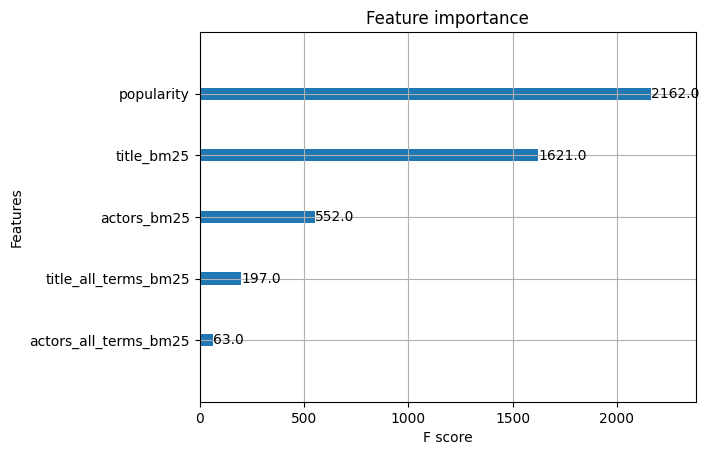

In [47]:
from xgboost import plot_importance

plot_importance(ranker, importance_type="weight");

## モデルをElasticsearchにインポート

モデルの学習が完了したら、o19sのLtRプラグインのエンドポイントを使ってElasticsearchにロードすることができます。

モデルはfeature setに対して登録します。このタイミングでモデルにFeature Setがコピーされ、
`_model`にモデルが登録されます。

In [48]:
def submit_model(featureset, index, model_name, model_payload):
    model_ep = "{}/_model/".format(LTR_ENDPOINT)
    create_ep = "{}/_featureset/{}/_createmodel".format(LTR_ENDPOINT, featureset)

    resp = requests.delete('{}{}'.format(model_ep, model_name))
    print('Delete model {}: {}'.format(model_name, resp.status_code))

    resp = requests.post(create_ep, json=model_payload)
    resp_msg(msg="Created Model {}".format(model_name), resp=resp)

In [49]:
import json

model_dump = ranker.get_booster().get_dump(dump_format="json")
clean_model = []
for line in model_dump:
    clean_model.append(json.loads(line))


params = {
            'model': {
                'name': "xgb",
                'model': {
                    'type': 'model/xgboost+json',
                    'definition': clean_model
                }
            }
        }

submit_model(feature_set["featureset"]["name"], "movies", "xgb", params)



Delete model xgb: 404
Created Model xgb [Status: 200]


## Esに登録したモデルの確認

`_ltr/_model`エンドポイントを利用するとEsに登録されているモデルの情報が取得できる。


> o19sのLtRプラグインとは異なり、特徴量の抽出のための設定もモデルに紐づいて登録されたもののみとなる。試行錯誤する特徴量セットについては自身で別の場所（Gitのリポジトリなど）で管理する必要がある。
> [疑問]これ、学習の時とは別のltr_model_configを設定しちゃうと混乱するってことかな？

In [50]:
model_ep = "{}/_model/".format(LTR_ENDPOINT)
res = requests.get(model_ep)
print(res.content)
#print(json.dumps(res, indent=2))

b'{"took":3,"timed_out":false,"_shards":{"total":1,"successful":1,"skipped":0,"failed":0},"hits":{"total":{"value":1,"relation":"eq"},"max_score":0.0,"hits":[{"_index":".ltrstore","_id":"model-xgb","_score":0.0,"_source":{"name":"xgb","type":"model","model":{"name":"xgb","feature_set":{"name":"movies_fieatures","features":[{"name":"title_bm25","params":["query"],"template_language":"mustache","template":{"match":{"title":"{{query}}"}}},{"name":"actors_bm25","params":["query"],"template_language":"mustache","template":{"match":{"actors":"{{query}}"}}},{"name":"title_all_terms_bm25","params":["query"],"template_language":"mustache","template":{"match":{"title":{"query":"{{query}}","minimum_should_match":"100%"}}}},{"name":"actors_all_terms_bm25","params":["query"],"template_language":"mustache","template":{"match":{"actors":{"query":"{{query}}","minimum_should_match":"100%"}}}},{"name":"popularity","params":[],"template_language":"mustache","template":{"script_score":{"query":{"exists":{

## rescorerの利用（検索）

モデルがElasticsearchにアップロードされると、この例のように_search APIのrescorerとして使用できるようになります：

```
GET /movies/_search
{
   "query" : {
      "multi_match" : {
         "query": "star wars",
         "fields": ["title", "overview", "actors", "director", "tags", "characters"]
      }
   },
   "rescore" : {
      "window_size" : 100,
      "query": {
         "rescore_query": {
               "sltr": {
                  "params": {"query": query},
                  "model": "xgb"
               }
         }
      }
   }
}
```

In [51]:
query = "star wars"

# まずは、Rescorerを利用しない検索結果
search_fields = ["title", "overview", "actors", "director", "tags", "characters"]
bm25_query = {"multi_match": {"query": query, "fields": search_fields}}

bm25_search_response = es_client.search(index=MOVIE_INDEX, query=bm25_query)

pd.DataFrame(
    columns=["title", "score", "id"],
    data=[
    (movie["_source"]["title"], movie["_score"], movie["_id"])
    for movie in bm25_search_response["hits"]["hits"]
])

,title,score,id
0,Star Wars,10.971989,11
1,Star Wars: The Clone Wars,9.923633,12180
2,Andor: A Disney+ Day Special Look,8.988029,1022100
3,Family Guy Presents: It's a Trap!,8.845748,278427
4,Star Wars: The Rise of Skywalker,8.053349,181812
5,Star Wars: The Force Awakens,8.053349,140607
6,Star Wars: The Last Jedi,8.053349,181808
7,Solo: A Star Wars Story,8.053349,348350
8,The Star Wars Holiday Special,8.053349,74849
9,Phineas and Ferb: Star Wars,8.053349,392216


In [52]:
# 次にRescorerを利用した検索結果:

ltr_rescorer = {
    "query": {
        "rescore_query": {
            "sltr": {
                "params": {"query": query},
                "model": "xgb"
            }
        }
    },
    "window_size": 100,
}

rescored_search_response = es_client.search(
    index=MOVIE_INDEX, query=bm25_query, rescore=ltr_rescorer
)

pd.DataFrame(
    columns=["title", "score", "id"],
    data=[
    (movie["_source"]["title"], movie["_score"], movie["_id"])
    for movie in rescored_search_response["hits"]["hits"]
]
)

,title,score,id
0,Star Wars,14.432244,11
1,Star Wars: The Clone Wars,12.504222,12180
2,Solo: A Star Wars Story,9.415101,348350
3,Star Wars: The Force Awakens,9.134558,140607
4,Star Wars: The Last Jedi,9.134558,181808
5,Star Wars: The Rise of Skywalker,9.037114,181812
6,The Star Wars Holiday Special,8.531041,74849
7,LEGO Star Wars Summer Vacation,8.351536,980804
8,Phineas and Ferb: Star Wars,8.342089,392216
9,Rogue One: A Star Wars Story,7.479788,330459


上の特徴量の重要度グラフでも示されているように、この結果リストでは、`title_bm25` と `popularity` の特徴量が学習済みモデルで高いウェイトを占めていることがわかる。 全ての検索結果でタイトルにクエリ用語が含まれていることから、`title_bm25`特徴の重要性がわかる。 同様に、より人気のある映画が上位にランクインするようになり、例えば「ローグ・ワン/スター・ウォーズ・ストーリー」は6位にランクインしている。

> （学習のタイミングによっては順位は変わってるかもしれない。。。）


In [53]:
query = "transformers dark of the moon"

# まずは、Rescorerを利用しない検索結果
search_fields = ["title", "overview", "actors", "director", "tags", "characters"]
bm25_query = {"multi_match": {"query": query, "fields": search_fields}}

bm25_search_response = es_client.search(index=MOVIE_INDEX, query=bm25_query)

pd.DataFrame(
    columns=["title", "score", "id"],
    data=[
    (movie["_source"]["title"], movie["_score"], movie["_id"])
    for movie in bm25_search_response["hits"]["hits"]
])

,title,score,id
0,The Princess,19.032303,913868
1,Transformers: Dark of the Moon,16.881004,38356
2,Transformers: Age of Extinction,14.156845,91314
3,Sex and Zen II,12.588331,74887
4,Hero,11.331474,79
5,A Trip to the Moon,11.195643,775
6,The Adventures of Baron Munchausen,10.449968,14506
7,Spaceballs,10.409368,957
8,Lucy,10.315710,240832
9,Enemy,10.266146,181886


In [54]:
# 次にRescorerを利用した検索結果:

ltr_rescorer = {
    "query": {
        "rescore_query": {
            "sltr": {
                "params": {"query": query},
                "model": "xgb"
            }
        }
    },
    "window_size": 100,
}

rescored_search_response = es_client.search(
    index=MOVIE_INDEX, query=bm25_query, rescore=ltr_rescorer
)

pd.DataFrame(
    columns=["title", "score", "id"],
    data=[
    (movie["_source"]["title"], movie["_score"], movie["_id"])
    for movie in rescored_search_response["hits"]["hits"]
]
)

,title,score,id
0,Transformers: Dark of the Moon,21.412483,38356
1,The Princess,19.191133,913868
2,Transformers: Age of Extinction,15.495416,91314
3,Transformers,9.908006,1858
4,Moon,9.033515,17431
5,A Trip to the Moon,8.979654,775
6,Sex and Zen II,8.931367,74887
7,Hero,8.544397,79
8,Transformers: The Last Knight,8.477195,335988
9,Lucy,7.868071,240832
